In [8]:
from nba_api.stats.endpoints import playercareerstats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nba_api.stats.static import players

# get_players returns a list of dictionaries, each representing a player.
nba_players = players.get_players()

def cleanCarData(name):
    """
    This function cleans the data for a given player and removes any duplicate rows from the dataframe
    based on the SEASON_ID column. It also includes the total row for each season and sorts the data by SEASON_ID.
    """
    # get player data
    player = getPlayerID(name)
    player = plotPlayerStats(player)

    # drop any duplicate rows
    player_drop = player.drop_duplicates()

    # get the 'TOT' rows for each season
    player_tot = player_drop[player_drop['TEAM_ABBREVIATION'] == 'TOT']

    # remove any duplicate SEASON_ID rows that are not 'TOT'
    player_dup = player_drop.duplicated(subset=['SEASON_ID'], keep=False)
    out = player[~player_dup]

    # combine the 'TOT' rows with the cleaned dataframe and sort by SEASON_ID
    out_tot = pd.concat([out, player_tot])
    return out_tot.sort_values(by=['SEASON_ID'])


def plotPlayerStats(id):
    """Returns a dataframe containing the player's career statistics."""
    career = playercareerstats.PlayerCareerStats(player_id=id)
    return career.get_data_frames()[0]


def getPlayerID(Name):
    """Returns the player ID for a given player name."""
    nba_players = players.get_players()
    ID = [player for player in nba_players
          if player['full_name'] == Name][0]
    return ID['id']


def plotPts(player):
    """Plots the player's points per game over time."""
    plot_stats(plotPlayerStats(getPlayerID(player)),['PTS'])
    
def plotCarStats(player):
    """Plots the player's career statistics over time."""
    plotPlayerStats(getPlayerID(player))

def plot_stats(df, stat_list):
    """
    Plots multiple stats over time for a given DataFrame.
    The stat_list parameter should be a list of column names to plot.
    """
    # create a new DataFrame with only the specified columns
    stat_df = df[stat_list + ['SEASON_ID']]

    # set the index to the season ID column
    stat_df.set_index('SEASON_ID', inplace=True)

    # plot each stat on a separate axis
    fig, ax = plt.subplots(figsize=(20, 10))
    for i, stat in enumerate(stat_list):
        # plot the stat on the current axis
        ax.plot(stat_df.index, stat_df[stat], label=stat, color=plt.cm.get_cmap('Set1')(i/len(stat_list)))
        ax.tick_params(axis='y', labelcolor=plt.cm.get_cmap('Set1')(i/len(stat_list)))
        
    # set axis labels and title
    ax.set_xlabel('Season', fontsize=20)
    ax.set_ylabel('Stats', fontsize=20)
    ax.set_title('Stats over time', fontsize=24)
    
    # set the y axis limits and ticks
    ax.set_ylim([0, df[stat_list].max().max()])
    y_ticks = np.arange(0, df[stat_list].max().max(), df[stat_list].max().max() / 5)
    ax.set_yticks(y_ticks)
    ax.tick_params(axis='both', labelsize=16)
    
    # create a legend for the plot
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='upper left', fontsize=16)

    # adjust the layout of the plot
    plt.subplots_adjust(left=0.15, bottom=0.15)

    # rotate x-axis labels
    plt.xticks(rotation=90)

    # show the plot
    plt.show()

    
def plotPAR(player):
    """Plot a players career PTS AST and REB"""
    plot_stats(player,['PTS','AST','REB'])

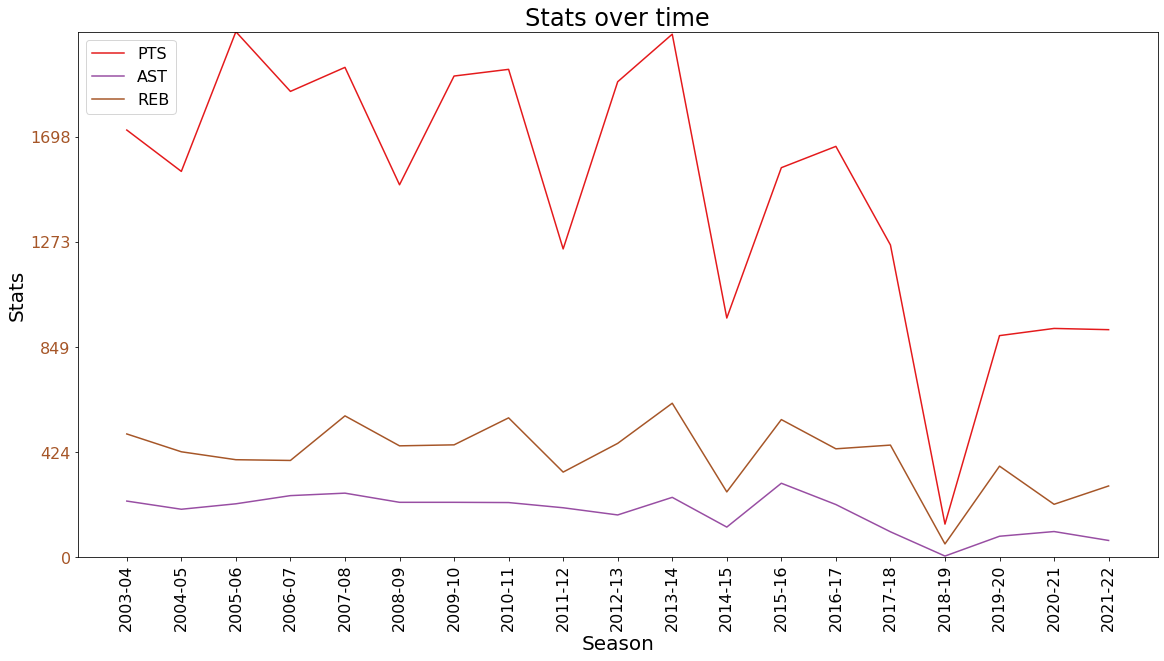

In [10]:
plotPAR(cleanCarData("Carmelo Anthony"))